# TF-ILF/TF-IDFを用いたログ解析

TF-ILF/TF-IDFを用いて特徴量抽出を行い、教師あり学習/半教師あり学習(PU Learning)を実施する。

# Import

In [1]:
!pip install pulearn

In [2]:
# import
import os
import sys
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import  StratifiedKFold
from sklearn.model_selection import  GridSearchCV
import lightgbm as lgb
from pulearn import BaggingPuClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

sys.path.append(os.path.join(os.path.dirname("__file__"), "./src/"))
import load_log
from data_preprocessing import FeatureExtraction
from model import PUAdapter, PUAdapterWrapper

C:\Users\81901\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


# Config

In [3]:
class Config:
    log_path = "./data/bgl/BGL_2k.log"
    train_size = 0.8
    output_dir = "./model/"
config = Config

# データ取得&データ前処理
* **`df`**
   * `log` : 生ログデータ
   * `log(after)` : 正規表現によるデータ加工後のログデータ(各ログ固有の値(IPアドレスなど)は削除する)
   * `label`: 0(正常) or 1(異常)

In [4]:
df = load_log.load_bgl(config)
display(df)

,log,log(after),label,category
0,2005.06.03 R02-M1-N0-C:J12-U11 2005-06-03-15.4...,RAS KERNEL INFO instruction cache parity error...,0,normal
1,2005.06.03 R02-M1-N0-C:J12-U11 2005-06-03-15.4...,RAS KERNEL INFO instruction cache parity error...,0,normal
2,2005.06.03 R02-M1-N0-C:J12-U11 2005-06-03-15.4...,RAS KERNEL INFO instruction cache parity error...,0,normal
3,2005.06.03 R02-M1-N0-C:J12-U11 2005-06-03-15.4...,RAS KERNEL INFO instruction cache parity error...,0,normal
4,2005.06.03 R23-M0-NE-C:J05-U01 2005-06-03-16.4...,NE NE RAS KERNEL INFO double hummer alignment ...,0,normal
...,...,...,...,...
1995,2005.12.26 R37-M1-NC-C:J02-U11 2005-12-26-22.3...,NC NC RAS KERNEL INFO instruction cache parity...,0,normal
1996,2005.12.26 R37-M1-NC-C:J02-U11 2005-12-26-23.4...,NC NC RAS KERNEL INFO instruction cache parity...,0,normal
1997,2005.12.26 R37-M1-NC-C:J02-U11 2005-12-26-23.4...,NC NC RAS KERNEL INFO instruction cache parity...,0,normal
1998,2005.12.27 R37-M1-NC-C:J02-U11 2005-12-27-01.2...,NC NC RAS KERNEL INFO instruction cache parity...,0,normal


# EDA
正常/異常データ件数や異常の種類別件数等を確認する。

In [5]:
print("ログデータ(正常)")
display(df[df["label"]==0].head())
print("ログデータ(異常)")
display(df[df["label"]==1].head())
print("異常/正常別 件数")
display(pd.DataFrame(df["label"].value_counts(), columns=["label"]))
print("異常種類別 件数")
display(pd.DataFrame(df["category"].value_counts()))

ログデータ(正常)


,log,log(after),label,category
0,2005.06.03 R02-M1-N0-C:J12-U11 2005-06-03-15.4...,RAS KERNEL INFO instruction cache parity error...,0,normal
1,2005.06.03 R02-M1-N0-C:J12-U11 2005-06-03-15.4...,RAS KERNEL INFO instruction cache parity error...,0,normal
2,2005.06.03 R02-M1-N0-C:J12-U11 2005-06-03-15.4...,RAS KERNEL INFO instruction cache parity error...,0,normal
3,2005.06.03 R02-M1-N0-C:J12-U11 2005-06-03-15.4...,RAS KERNEL INFO instruction cache parity error...,0,normal
4,2005.06.03 R23-M0-NE-C:J05-U01 2005-06-03-16.4...,NE NE RAS KERNEL INFO double hummer alignment ...,0,normal


ログデータ(異常)


,log,log(after),label,category
8,2005.06.04 R04-M1-N4-I:J18-U11 2005-06-04-00.2...,RAS APP FATAL ciod failed to read message pref...,1,APPREAD
9,2005.06.04 R27-M1-N4-I:J18-U01 2005-06-04-00.2...,RAS APP FATAL ciod failed to read message pref...,1,APPREAD
103,2005.06.11 R30-M0-N9-C:J16-U01 2005-06-11-17.3...,RAS KERNEL FATAL data TLB error interrupt,1,KERNDTLB
104,2005.06.11 R30-M0-N9-C:J16-U01 2005-06-11-17.4...,RAS KERNEL FATAL data TLB error interrupt,1,KERNDTLB
105,2005.06.11 R30-M0-N9-C:J16-U01 2005-06-11-17.4...,RAS KERNEL FATAL data TLB error interrupt,1,KERNDTLB


異常/正常別 件数


,label
0,1857
1,143


異常種類別 件数


,category
normal,1857
KERNDTLB,60
KERNSTOR,30
APPSEV,17
KERNMNTF,11
KERNTERM,7
KERNREC,5
APPRES,4
APPREAD,3
KERNRTSP,2


# データ分割  


* **`学習用データ`**  
    * `log`: 生ログデータ
    * `label`: 0(未知の正常) or 1(未知の異常) or -1(既知として扱う異常)
    * `category` : 異常の種類(正常の場合はnormal)
  
* **`推論用データ`**  
    * 正常データ(unlabel) ： 
    * 異常データ(unlabel) ：
    * 正常データ(label) ：
    * 異常データ(label) ：

In [6]:
# データ分割
train, test = train_test_split(df, train_size=config.train_size, random_state=1, shuffle=True)
# 各データの異常件数
train_info = train.groupby(["label", "category"]).size()
train_info = pd.DataFrame(train_info).rename(columns={0:"count"}).sort_values(["label", "count"], ascending=False)
print(" ----- + 学習データの異常別件数 + -----")
display(train_info)
test_info = test.groupby(["label", "category"]).size()
test_info = pd.DataFrame(test_info).rename(columns={0:"count"}).sort_values(["label", "count"], ascending=False)
print(" ----- + 推論データの異常別件数 + -----")
display(test_info)

 ----- + 学習データの異常別件数 + -----


count
label category       
1     KERNDTLB     48
      KERNSTOR     23
      APPSEV       13
      KERNMNTF      7
      KERNTERM      6
      KERNREC       4
      APPRES        3
      APPREAD       2
      APPTO         2
      KERNRTSP      2
      APPCHILD      1
      APPOUT        1
0     normal     1488

 ----- + 推論データの異常別件数 + -----


count
label category       
1     KERNDTLB     12
      KERNSTOR      7
      APPSEV        4
      KERNMNTF      4
      APPREAD       1
      APPRES        1
      KERNREC       1
      KERNTERM      1
0     normal      369

# 特徴量抽出
特徴量抽出では、TF-IDFおよびTF-ILFを用いてtrain/testの列「log(after)」の特徴量抽出を実施する。

In [7]:
# 特徴量抽出するデータの確認
display(train)
display(test)

,log,log(after),label,category
0,2005.06.03 R02-M1-N0-C:J12-U11 2005-06-03-15.4...,RAS KERNEL INFO instruction cache parity error...,0,normal
816,2005.07.10 R24-M1-N6-C:J05-U01 2005-07-10-07.4...,RAS KERNEL INFO generating core,0,normal
790,2005.07.09 R35-M0-NE-C:J03-U11 2005-07-09-21.2...,NE NE RAS KERNEL INFO generating core,0,normal
361,2005.06.20 R14-M1-N0-I:J18-U01 2005-06-20-16.2...,RAS APP FATAL ciod Error loading home draeger ...,0,normal
592,2005.07.04 R34-M0-N5-C:J04-U01 2005-07-04-07.3...,RAS KERNEL INFO generating core,0,normal
...,...,...,...,...
1791,2005.11.26 R54-M0-N0-I:J18-U01 2005-11-26-04.4...,RAS APP FATAL ciod Error reading message prefi...,1,APPSEV
1096,2005.07.23 R24-M1-N2-C:J02-U01 2005-07-23-11.4...,RAS KERNEL INFO generating core,0,normal
1932,2005.12.03 R06-M1-NF-C:J12-U01 2005-12-03-07.5...,NF NF RAS KERNEL INFO ddr error s detected and...,0,normal
235,2005.06.14 R26-M0-N5-C:J08-U01 2005-06-14-10.2...,RAS KERNEL FATAL program interrupt illegal ins...,0,normal


,log,log(after),label,category
674,2005.07.09 R22-M1-N0-C:J05-U11 2005-07-09-11.5...,RAS KERNEL INFO generating core,0,normal
1699,2005.11.08 R62-M0-N2-C:J13-U11 2005-11-08-10.0...,RAS KERNEL INFO iar dear,0,normal
1282,2005.08.26 R62-M1-N3-C:J04-U01 2005-08-26-11.4...,RAS KERNEL INFO iar dear,0,normal
1315,2005.08.26 R65-M0-N3-C:J04-U01 2005-08-26-12.2...,RAS KERNEL INFO double hummer alignment except...,0,normal
1210,2005.08.03 NULL 2005-08-03-16.12.54.271533 NUL...,NULL NULL RAS MMCS ERROR idoproxydb hit ASSERT...,0,normal
...,...,...,...,...
400,2005.06.25 R21-M1-N7-C:J10-U01 2005-06-25-09.0...,RAS KERNEL INFO generating core,0,normal
763,2005.07.09 R25-M1-NF-C:J10-U11 2005-07-09-21.0...,NF NF RAS KERNEL INFO generating core,0,normal
385,2005.06.24 R36-M0-N5-C:J03-U01 2005-06-24-22.3...,RAS KERNEL INFO CE sym at mask,0,normal
1667,2005.11.04 R63-M0-ND-C:J15-U01 2005-11-04-13.3...,ND ND RAS KERNEL INFO iar dear,0,normal


In [8]:
#tf-ilf
train_ilf, vocabulary_ilf = FeatureExtraction(train["log(after)"].values, config, mode="train", fe_type="tfilf")()
test_ilf, _ = FeatureExtraction(test["log(after)"].values, config, mode="test", fe_type="tfilf")()
train_ilf["label"] = train["label"].values
test_ilf["label"] = test["label"].values
print("===== tf-ilf =====")
display(train_ilf)
display(test_ilf)

#tf-idf
train_idf, vocabulary_idf = FeatureExtraction(train["log(after)"].values, config, mode="train", fe_type="tfidf")()
test_idf, _ = FeatureExtraction(test["log(after)"].values, config, mode="test", fe_type="tfidf")()
train_idf["label"] = train["label"].values
test_idf["label"] = test["label"].values
print("===== tf-idf =====")
display(train_idf)
display(test_idf)

===== tf-ilf =====


,0,1,2,3,4,5,6,7,8,9,...,432,433,434,435,436,437,438,439,440,label
0,3.578531,3.578531,3.578531,2.887875,2.887875,3.174726,1.636895,2.483241,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,3.578531,3.578531,3.578531,0.000000,0.000000,0.000000,0.000000,0.000000,3.578531,2.66523,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,3.578531,3.578531,3.578531,0.000000,0.000000,0.000000,0.000000,0.000000,3.578531,2.66523,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,3.578531,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,3.578531,3.578531,3.578531,0.000000,0.000000,0.000000,0.000000,0.000000,3.578531,2.66523,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,3.578531,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1596,3.578531,3.578531,3.578531,0.000000,0.000000,0.000000,0.000000,0.000000,3.578531,2.66523,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1597,3.578531,3.578531,3.578531,0.000000,0.000000,0.000000,1.636895,2.483241,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1598,3.578531,3.578531,0.000000,2.887875,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


,0,1,2,3,4,5,6,7,8,9,...,432,433,434,435,436,437,438,439,440,label
0,3.550361,3.550361,3.550361,0.0,0.0,0.0,0.0,0.0,3.550361,2.637059,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,3.550361,3.550361,3.550361,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,3.550361,3.550361,3.550361,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,3.550361,3.550361,3.550361,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,3.550361,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,3.550361,3.550361,3.550361,0.0,0.0,0.0,0.0,0.0,3.550361,2.637059,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
396,3.550361,3.550361,3.550361,0.0,0.0,0.0,0.0,0.0,3.550361,2.637059,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
397,3.550361,3.550361,3.550361,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
398,3.550361,3.550361,3.550361,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


===== tf-idf =====


,0,1,2,3,4,5,6,7,8,9,...,432,433,434,435,436,437,438,439,440,label
0,6.679624,6.679624,6.679624,5.988968,5.988968,6.275819,4.737988,5.584334,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,6.679624,6.679624,6.679624,0.000000,0.000000,0.000000,0.000000,0.000000,6.679624,5.766323,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,6.679624,6.679624,6.679624,0.000000,0.000000,0.000000,0.000000,0.000000,6.679624,5.766323,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,6.679624,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,6.679624,6.679624,6.679624,0.000000,0.000000,0.000000,0.000000,0.000000,6.679624,5.766323,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,6.679624,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1596,6.679624,6.679624,6.679624,0.000000,0.000000,0.000000,0.000000,0.000000,6.679624,5.766323,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1597,6.679624,6.679624,6.679624,0.000000,0.000000,0.000000,4.737988,5.584334,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1598,6.679624,6.679624,0.000000,5.988968,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


,0,1,2,3,4,5,6,7,8,9,...,432,433,434,435,436,437,438,439,440,label
0,5.29333,5.29333,5.29333,0.0,0.0,0.0,0.0,0.0,5.29333,4.380029,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,5.29333,5.29333,5.29333,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,5.29333,5.29333,5.29333,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,5.29333,5.29333,5.29333,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,5.29333,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,5.29333,5.29333,5.29333,0.0,0.0,0.0,0.0,0.0,5.29333,4.380029,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
396,5.29333,5.29333,5.29333,0.0,0.0,0.0,0.0,0.0,5.29333,4.380029,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
397,5.29333,5.29333,5.29333,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
398,5.29333,5.29333,5.29333,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


# LightGBM
LightGBMを利用して教師あり学習を実行してログの正常/異常を分類する。

In [9]:
# モデルのインスタンス生成&学習実行
params = {"max_length": [5,8,10]}
clf_ilf = GridSearchCV(lgb.LGBMClassifier(verbose=-1), params, cv=StratifiedKFold(n_splits=5), scoring="recall_macro")
clf_idf = GridSearchCV(lgb.LGBMClassifier(verbose=-1), params, cv=StratifiedKFold(n_splits=5), scoring="recall_macro")
model_ilf = clf_ilf.fit(train_ilf.iloc[:,:-1].values, train_ilf["label"].values) # TF-ILFで特徴量抽出したデータでモデル生成
model_idf = clf_idf.fit(train_idf.iloc[:,:-1].values, train_idf["label"].values) # TF-IDFで特徴量抽出したデータでモデル生成

[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown pa

## スコア表示(学習時)
混同行列および各評価指標の値を表示する。

--- TF-IlF ---


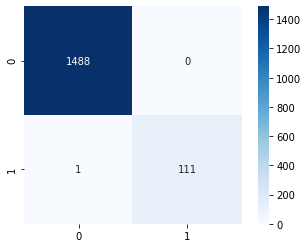

--- TF-IDF ---


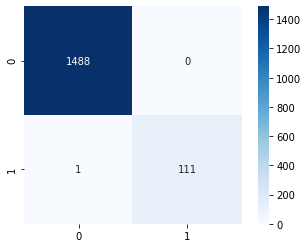

In [10]:
### 学習時のスコア表示
# 予測値のデータ生成
y_pred_ilf = model_ilf.predict(train_ilf.iloc[:,:-1].values)
y_pred_idf = model_idf.predict(train_idf.iloc[:,:-1].values)
# スコア算出
cm_ilf = confusion_matrix(train_ilf["label"].values, y_pred_ilf)
cm_idf = confusion_matrix(train_idf["label"].values, y_pred_idf)
classification_result_ilf = pd.DataFrame(classification_report(train_ilf["label"].values, y_pred_ilf, output_dict=True)).T
classification_result_idf = pd.DataFrame(classification_report(train_idf["label"].values, y_pred_idf, output_dict=True)).T
# TF-ILF
print("--- TF-IlF ---")
sns.heatmap(cm_ilf, square=True, cbar=True, annot=True, cmap='Blues', fmt='d')
plt.show()
#display(classification_result_ilf)
# TF-IDF
print("--- TF-IDF ---")
sns.heatmap(cm_idf, square=True, cbar=True, annot=True, cmap='Blues', fmt='d')
plt.show()
#display(classification_result_idf)

## キーワード抽出
特徴量重要度からキーワードを抽出する。

In [11]:
# 特徴量重要度(重要視している単語)
print("--- TF-IlF ---")
fi_ilf = pd.DataFrame({"word": vocabulary_ilf.keys(), "importance":model_ilf.best_estimator_.feature_importances_})
fi_ilf = fi_ilf.sort_values("importance", ascending=False)
display(fi_ilf.head(10))
print("--- TF-IDF ---")
fi_idf = pd.DataFrame({"word": vocabulary_idf.keys(), "importance":model_idf.best_estimator_.feature_importances_})
fi_idf = fi_idf.sort_values("importance", ascending=False)
display(fi_idf.head(10))

--- TF-IlF ---


,word,importance
101,NC,94
167,rts,92
6,error,88
12,FATAL,88
14,Error,75
83,on,72
96,point,62
51,storage,62
22,or,58
1,KERNEL,57


--- TF-IDF ---


,word,importance
101,NC,94
167,rts,92
6,error,88
12,FATAL,88
14,Error,75
83,on,72
96,point,62
51,storage,62
22,or,58
1,KERNEL,57


## スコア表示(推論時)
混同行列および各評価指標の値を表示する。

--- TF-IlF ---


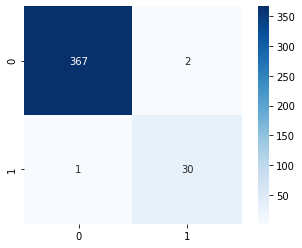

--- TF-IDF ---


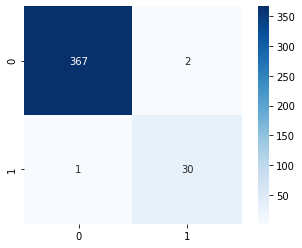

In [12]:
### 推論時のスコア表示
# 予測値のデータ生成
y_pred_ilf = model_ilf.predict(test_ilf.iloc[:,:-1].values)
y_pred_idf = model_idf.predict(test_idf.iloc[:,:-1].values)
# スコア算出
cm_ilf = confusion_matrix(test_ilf["label"].values, y_pred_ilf)
cm_idf = confusion_matrix(test_idf["label"].values, y_pred_idf)
classification_result_ilf = pd.DataFrame(classification_report(test_ilf["label"].values, y_pred_ilf, output_dict=True)).T
classification_result_idf = pd.DataFrame(classification_report(test_idf["label"].values, y_pred_idf, output_dict=True)).T
# TF-ILF
print("--- TF-IlF ---")
sns.heatmap(cm_ilf, square=True, cbar=True, annot=True, cmap='Blues', fmt='d')
plt.show()
#display(classification_result_ilf)
# TF-IDF
print("--- TF-IDF ---")
sns.heatmap(cm_idf, square=True, cbar=True, annot=True, cmap='Blues', fmt='d')
plt.show()
#display(classification_result_idf)

In [13]:
# 異常ログの可視化
test_tmp = test.copy()
test_tmp["y_true"] = test_ilf["label"].values
test_tmp["y_pred"] = y_pred_ilf
test_tmp = test_tmp[["log", "y_pred", "y_true"]].reset_index()
del test_tmp["index"]
def highlight_greaterthan(s, threshold, column):
    is_max = pd.Series(data=False, index=s.index)
    is_max[column] = s.loc[column] >= threshold
    return ['background-color: red' if is_max.any() else '' for v in is_max]
test_tmp.style.apply(highlight_greaterthan, threshold=1.0, column=['y_pred'], axis=1)

,log,y_pred,y_true
0,2005.07.09 R22-M1-N0-C:J05-U11 2005-07-09-11.53.58.430277 R22-M1-N0-C:J05-U11 RAS KERNEL INFO generating core.7167,0,0
1,2005.11.08 R62-M0-N2-C:J13-U11 2005-11-08-10.09.13.667082 R62-M0-N2-C:J13-U11 RAS KERNEL INFO iar 001061e8 dear 0247012c,0,0
2,2005.08.26 R62-M1-N3-C:J04-U01 2005-08-26-11.47.33.903841 R62-M1-N3-C:J04-U01 RAS KERNEL INFO iar 003a90fc dear 00b360e8,0,0
3,2005.08.26 R65-M0-N3-C:J04-U01 2005-08-26-12.26.40.236812 R65-M0-N3-C:J04-U01 RAS KERNEL INFO 1524480 double-hummer alignment exceptions,0,0
4,"2005.08.03 NULL 2005-08-03-16.12.54.271533 NULL RAS MMCS ERROR idoproxydb hit ASSERT condition: ASSERT expression=0 Source file=idotransportmgr.cpp Source line=1043 Function=int IdoTransportMgr::SendPacket(IdoUdpMgr*, BglCtlPavTrace*)",0,0
5,2005.11.04 R62-M0-NC-C:J04-U01 2005-11-04-09.52.27.280593 R62-M0-NC-C:J04-U01 RAS KERNEL INFO iar 0010686c dear 02f6951c,0,0
6,2005.07.07 R12-M1-NE-C:J04-U11 2005-07-07-18.41.19.670878 R12-M1-NE-C:J04-U11 RAS KERNEL INFO generating core.815,0,0
7,2005.06.26 R05-M0-N7-C:J13-U01 2005-06-26-10.28.59.279042 R05-M0-N7-C:J13-U01 RAS KERNEL INFO program interrupt,0,0
8,2005.07.23 R17-M0-N1-C:J06-U11 2005-07-23-17.45.15.142194 R17-M0-N1-C:J06-U11 RAS KERNEL INFO generating core.14250,0,0
9,2005.07.10 R26-M1-N9-C:J02-U01 2005-07-10-07.42.50.396450 R26-M1-N9-C:J02-U01 RAS KERNEL INFO generating core.3851,0,0


# PU Learning①
* **`PU Learningとは`**
    * 一部の異常データのみラベルを付けて学習/推論を実施する。  
      学習時の一部の異常データのラベルを1、それ以外(正常/残りの異常データ)のラベルを0とする。

* **`label`** : ラベル付けされている異常ログ=1、ラベル付けされていない正常/異常データ=0とする。

* **`参考`** : https://data-analysis-stats.jp/%e6%a9%9f%e6%a2%b0%e5%ad%a6%e7%bf%92/pulearn%e3%81%a7%e3%81%ae%e9%99%bd%e6%80%a7%e3%81%ae%e3%83%a9%e3%83%99%e3%83%ab%e3%81%a8%e3%83%a9%e3%83%99%e3%83%ab%e3%81%aa%e3%81%97%e3%83%87%e3%83%bc%e3%82%bf%e3%81%ae%e5%88%86%e9%a1%9e%e5%88%86/

In [14]:
# ラベルの生成
label_ratio = 0.5 # label付けする異常データの割合
hidden_size = int(train_ilf[train_ilf["label"]==1].shape[0] * (1 - label_ratio))
# TF-ILF
train_ilf["use_label"] = train_ilf["label"].values
train_ilf.loc[np.random.choice(train_ilf[train_ilf["label"] == 1].index, replace=False, size=hidden_size),"use_label"] = 0
# TF-IDF
train_idf["use_label"] = train_idf["label"].values
train_idf.loc[np.random.choice(train_idf[train_idf["label"] == 1].index, replace=False, size=hidden_size),"use_label"] = 0
display(train_ilf)
display(train_idf)

,0,1,2,3,4,5,6,7,8,9,...,433,434,435,436,437,438,439,440,label,use_label
0,3.578531,3.578531,3.578531,2.887875,2.887875,3.174726,1.636895,2.483241,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
1,3.578531,3.578531,3.578531,0.000000,0.000000,0.000000,0.000000,0.000000,3.578531,2.66523,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2,3.578531,3.578531,3.578531,0.000000,0.000000,0.000000,0.000000,0.000000,3.578531,2.66523,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
3,3.578531,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
4,3.578531,3.578531,3.578531,0.000000,0.000000,0.000000,0.000000,0.000000,3.578531,2.66523,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,3.578531,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
1596,3.578531,3.578531,3.578531,0.000000,0.000000,0.000000,0.000000,0.000000,3.578531,2.66523,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
1597,3.578531,3.578531,3.578531,0.000000,0.000000,0.000000,1.636895,2.483241,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
1598,3.578531,3.578531,0.000000,2.887875,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0


,0,1,2,3,4,5,6,7,8,9,...,433,434,435,436,437,438,439,440,label,use_label
0,6.679624,6.679624,6.679624,5.988968,5.988968,6.275819,4.737988,5.584334,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
1,6.679624,6.679624,6.679624,0.000000,0.000000,0.000000,0.000000,0.000000,6.679624,5.766323,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2,6.679624,6.679624,6.679624,0.000000,0.000000,0.000000,0.000000,0.000000,6.679624,5.766323,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
3,6.679624,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
4,6.679624,6.679624,6.679624,0.000000,0.000000,0.000000,0.000000,0.000000,6.679624,5.766323,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,6.679624,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
1596,6.679624,6.679624,6.679624,0.000000,0.000000,0.000000,0.000000,0.000000,6.679624,5.766323,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
1597,6.679624,6.679624,6.679624,0.000000,0.000000,0.000000,4.737988,5.584334,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
1598,6.679624,6.679624,0.000000,5.988968,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0


In [15]:
print("----- TF-ILF -----")
print("本来の異常件数")
train_ilf_true = pd.DataFrame(train_ilf["label"].value_counts())
display(train_ilf_true)
print("利用する異常件数")
train_ilf_use = pd.DataFrame(train_ilf["use_label"].value_counts())
display(train_ilf_use)
print("----- TF-IDF -----")
print("本来の異常件数")
train_idf_true = pd.DataFrame(train_idf["label"].value_counts())
display(train_idf_true)
print("利用する異常件数")
train_idf_use = pd.DataFrame(train_idf["use_label"].value_counts())
display(train_idf_use)

----- TF-ILF -----
本来の異常件数


,label
0,1488
1,112


利用する異常件数


,use_label
0,1544
1,56


----- TF-IDF -----
本来の異常件数


,label
0,1488
1,112


利用する異常件数


,use_label
0,1544
1,56


## SVC

In [16]:
# インスタンス生成
svc_ilf = SVC(C=10, kernel="rbf", gamma=0.4, probability=True)
svc_idf = SVC(C=10, kernel="rbf", gamma=0.4, probability=True)
pu_estimator_ilf = BaggingPuClassifier(base_estimator=svc_ilf, n_estimators=15)
pu_estimator_idf = BaggingPuClassifier(base_estimator=svc_idf, n_estimators=15)
# 学習実行
pu_model_clf_ilf = pu_estimator_ilf.fit(train_ilf.iloc[:,:-2].values, train_ilf["use_label"])
pu_model_clf_idf = pu_estimator_idf.fit(train_idf.iloc[:,:-2].values, train_idf["use_label"])

--- TF-IlF ---


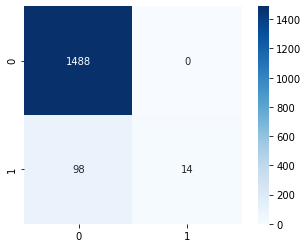

--- TF-IDF ---


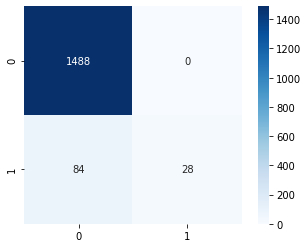

In [17]:
### 学習時のスコア表示
# 予測値のデータ生成
y_pred_ilf = pu_model_clf_ilf.predict(train_ilf.iloc[:,:-2].values)
y_pred_idf = pu_model_clf_idf.predict(train_idf.iloc[:,:-2].values)
# スコア算出
cm_ilf = confusion_matrix(train_ilf["label"].values, y_pred_ilf)
cm_idf = confusion_matrix(train_idf["label"].values, y_pred_idf)
classification_result_ilf = pd.DataFrame(classification_report(train_ilf["label"].values, y_pred_ilf, output_dict=True)).T
classification_result_idf = pd.DataFrame(classification_report(train_idf["label"].values, y_pred_idf, output_dict=True)).T
# TF-ILF
print("--- TF-IlF ---")
sns.heatmap(cm_ilf, square=True, cbar=True, annot=True, cmap='Blues', fmt='d')
plt.show()
#display(classification_result_ilf)
# TF-IDF
print("--- TF-IDF ---")
sns.heatmap(cm_idf, square=True, cbar=True, annot=True, cmap='Blues', fmt='d')
plt.show()
#display(classification_result_idf)

C:\Users\81901\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--- TF-IlF ---


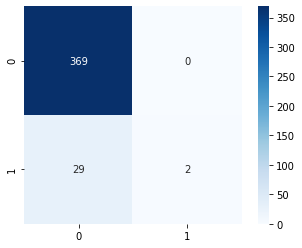

--- TF-IDF ---


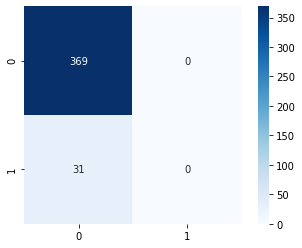

In [18]:
### 推論時のスコア表示
# 予測値のデータ生成
y_pred_ilf = pu_model_clf_ilf.predict(test_ilf.iloc[:,:-1].values)
y_pred_idf = pu_model_clf_idf.predict(test_idf.iloc[:,:-1].values)
# スコア算出
cm_ilf = confusion_matrix(test_ilf["label"].values, y_pred_ilf)
cm_idf = confusion_matrix(test_idf["label"].values, y_pred_idf)
classification_result_ilf = pd.DataFrame(classification_report(test_ilf["label"].values, y_pred_ilf, output_dict=True)).T
classification_result_idf = pd.DataFrame(classification_report(test_idf["label"].values, y_pred_idf, output_dict=True)).T
# TF-ILF
print("--- TF-IlF ---")
sns.heatmap(cm_ilf, square=True, cbar=True, annot=True, cmap='Blues', fmt='d')
plt.show()
#display(classification_result_ilf)
# TF-IDF
print("--- TF-IDF ---")
sns.heatmap(cm_idf, square=True, cbar=True, annot=True, cmap='Blues', fmt='d')
plt.show()
#display(classification_result_idf)

## LightGBM

In [19]:
# インスタンス生成
lgb_ilf = lgb.LGBMClassifier(verbose=-1, max_length=10)
lgb_idf = lgb.LGBMClassifier(verbose=-1, max_length=10)
pu_estimator_ilf = BaggingPuClassifier(base_estimator=lgb_ilf, n_estimators=15)
pu_estimator_idf = BaggingPuClassifier(base_estimator=lgb_idf, n_estimators=15)
# 学習実行
pu_model_clf_ilf = pu_estimator_ilf.fit(train_ilf.iloc[:,:-2].values, train_ilf["use_label"])
pu_model_clf_idf = pu_estimator_idf.fit(train_idf.iloc[:,:-2].values, train_idf["use_label"])

[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length


--- TF-IlF ---


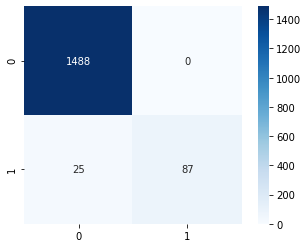

--- TF-IDF ---


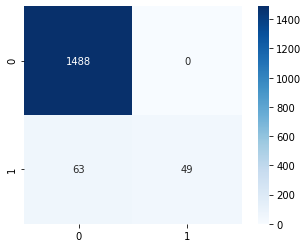

In [20]:
### 学習時のスコア表示
# 予測値のデータ生成
y_pred_ilf = pu_model_clf_ilf.predict(train_ilf.iloc[:,:-2].values)
y_pred_idf = pu_model_clf_idf.predict(train_idf.iloc[:,:-2].values)
# スコア算出
cm_ilf = confusion_matrix(train_ilf["label"].values, y_pred_ilf)
cm_idf = confusion_matrix(train_idf["label"].values, y_pred_idf)
classification_result_ilf = pd.DataFrame(classification_report(train_ilf["label"].values, y_pred_ilf, output_dict=True)).T
classification_result_idf = pd.DataFrame(classification_report(train_idf["label"].values, y_pred_idf, output_dict=True)).T
# TF-ILF
print("--- TF-IlF ---")
sns.heatmap(cm_ilf, square=True, cbar=True, annot=True, cmap='Blues', fmt='d')
plt.show()
#display(classification_result_ilf)
# TF-IDF
print("--- TF-IDF ---")
sns.heatmap(cm_idf, square=True, cbar=True, annot=True, cmap='Blues', fmt='d')
plt.show()
#display(classification_result_idf)

--- TF-IlF ---


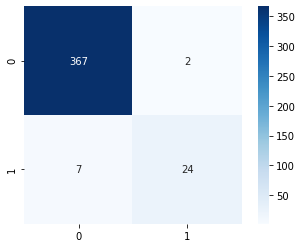

--- TF-IDF ---


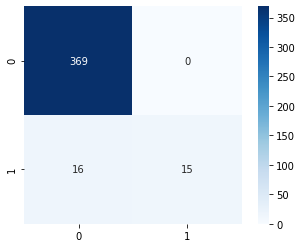

In [21]:
### 推論時のスコア表示
# 予測値のデータ生成
y_pred_ilf = pu_model_clf_ilf.predict(test_ilf.iloc[:,:-1].values)
y_pred_idf = pu_model_clf_idf.predict(test_idf.iloc[:,:-1].values)
# スコア算出
cm_ilf = confusion_matrix(test_ilf["label"].values, y_pred_ilf)
cm_idf = confusion_matrix(test_idf["label"].values, y_pred_idf)
classification_result_ilf = pd.DataFrame(classification_report(test_ilf["label"].values, y_pred_ilf, output_dict=True)).T
classification_result_idf = pd.DataFrame(classification_report(test_idf["label"].values, y_pred_idf, output_dict=True)).T
# TF-ILF
print("--- TF-IlF ---")
sns.heatmap(cm_ilf, square=True, cbar=True, annot=True, cmap='Blues', fmt='d')
plt.show()
#display(classification_result_ilf)
# TF-IDF
print("--- TF-IDF ---")
sns.heatmap(cm_idf, square=True, cbar=True, annot=True, cmap='Blues', fmt='d')
plt.show()
#display(classification_result_idf)

In [22]:
# 異常ログの可視化
test_tmp = test.copy()
test_tmp["y_true"] = test_ilf["label"].values
test_tmp["y_pred"] = y_pred_ilf
test_tmp = test_tmp[["log", "y_pred", "y_true"]].reset_index()
del test_tmp["index"]
def highlight_greaterthan(s, threshold, column):
    is_max = pd.Series(data=False, index=s.index)
    is_max[column] = s.loc[column] >= threshold
    return ['background-color: red' if is_max.any() else '' for v in is_max]
test_tmp.style.apply(highlight_greaterthan, threshold=1.0, column=['y_pred'], axis=1)

,log,y_pred,y_true
0,2005.07.09 R22-M1-N0-C:J05-U11 2005-07-09-11.53.58.430277 R22-M1-N0-C:J05-U11 RAS KERNEL INFO generating core.7167,0,0
1,2005.11.08 R62-M0-N2-C:J13-U11 2005-11-08-10.09.13.667082 R62-M0-N2-C:J13-U11 RAS KERNEL INFO iar 001061e8 dear 0247012c,0,0
2,2005.08.26 R62-M1-N3-C:J04-U01 2005-08-26-11.47.33.903841 R62-M1-N3-C:J04-U01 RAS KERNEL INFO iar 003a90fc dear 00b360e8,0,0
3,2005.08.26 R65-M0-N3-C:J04-U01 2005-08-26-12.26.40.236812 R65-M0-N3-C:J04-U01 RAS KERNEL INFO 1524480 double-hummer alignment exceptions,0,0
4,"2005.08.03 NULL 2005-08-03-16.12.54.271533 NULL RAS MMCS ERROR idoproxydb hit ASSERT condition: ASSERT expression=0 Source file=idotransportmgr.cpp Source line=1043 Function=int IdoTransportMgr::SendPacket(IdoUdpMgr*, BglCtlPavTrace*)",0,0
5,2005.11.04 R62-M0-NC-C:J04-U01 2005-11-04-09.52.27.280593 R62-M0-NC-C:J04-U01 RAS KERNEL INFO iar 0010686c dear 02f6951c,0,0
6,2005.07.07 R12-M1-NE-C:J04-U11 2005-07-07-18.41.19.670878 R12-M1-NE-C:J04-U11 RAS KERNEL INFO generating core.815,0,0
7,2005.06.26 R05-M0-N7-C:J13-U01 2005-06-26-10.28.59.279042 R05-M0-N7-C:J13-U01 RAS KERNEL INFO program interrupt,0,0
8,2005.07.23 R17-M0-N1-C:J06-U11 2005-07-23-17.45.15.142194 R17-M0-N1-C:J06-U11 RAS KERNEL INFO generating core.14250,0,0
9,2005.07.10 R26-M1-N9-C:J02-U01 2005-07-10-07.42.50.396450 R26-M1-N9-C:J02-U01 RAS KERNEL INFO generating core.3851,0,0
